In [75]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

#importing rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit import RDConfig
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
#from utility import FeatureGenerator
from rdkit.Chem import PandasTools as PandasTools
from rdkit import DataStructs
from rdkit.Chem.Subshape import SubshapeBuilder,SubshapeAligner,SubshapeObjects

#importing sklearn 
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

In [7]:
#load data
df = pd.read_csv("data.csv")
df.head()

,SMILES,CASRN,MOLECULEID,EXTERNALID,N,NAME,NAME.1,ARTICLEID,PUBMEDID,PAGE,TABLE,logPow {measured},UNIT {logPow},"logPow {measured, converted}",UNIT {logPow}.1,pH,UNIT {pH}
0,COC1=CC=CC=C1[C@@H]1CC(=O)NC2=C1C=C(C)C(C)=C2,-,M1018998,ZINC00036522,1,-,-,A27772,23131797,-,2,4.17,Log unit,4.17,Log unit,5.0,Log unit
1,COC1=CC=C2C(=O)C[C@](O)(OC2=C1)C(F)(F)F,-,M1019732,ZINC00185379,3,-,-,A27772,23131797,-,2,2.79,Log unit,2.79,Log unit,5.0,Log unit
2,CC(C)(C)C1(C)O[C@@H]([C@@H](O1)C(N)=O)C(N)=O,-,M3410220,ZINC12402487,4,-,-,A27772,23131797,-,2,1.60,Log unit,1.60,Log unit,= 6.5,Log unit
3,CCOC1=CC(=CC(OCC)=C1OCC)C1=NN=C(O1)C1=CC=CO1,-,M1019125,ZINC00055459,5,-,-,A27772,23131797,-,2,3.96,Log unit,3.96,Log unit,= 10.5,Log unit
4,CN(C)C1=CC=C(C=C1)C(=C)C1=CC=C(C=C1)N(C)C,-,M78769,ZINC00056871,6,-,-,A27772,23131797,-,2,5.30,Log unit,5.30,Log unit,= 7.3,Log unit


In [9]:
df.shape

(707, 17)

In [11]:
df.describe()

,N,PUBMEDID,TABLE,logPow {measured},"logPow {measured, converted}"
count,707.000000,707.0,707.0,707.000000,707.000000
mean,491.585573,23131797.0,2.0,4.188713,4.188713
std,291.618041,0.0,0.0,1.179046,1.179046
min,1.000000,23131797.0,2.0,0.300000,0.300000
25%,239.500000,23131797.0,2.0,3.460000,3.460000
50%,511.000000,23131797.0,2.0,4.330000,4.330000
75%,750.500000,23131797.0,2.0,4.980000,4.980000
max,995.000000,23131797.0,2.0,6.960000,6.960000


In [13]:
df.isnull().sum(axis=0)

SMILES                          0
CASRN                           0
MOLECULEID                      0
EXTERNALID                      0
N                               0
NAME                            0
NAME.1                          0
ARTICLEID                       0
PUBMEDID                        0
PAGE                            0
TABLE                           0
logPow {measured}               0
UNIT {logPow}                   0
logPow {measured, converted}    0
UNIT {logPow}.1                 0
pH                              0
UNIT {pH}                       0
dtype: int64

In [15]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707 entries, 0 to 706
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   SMILES                        707 non-null    object 
 1   CASRN                         707 non-null    object 
 2   MOLECULEID                    707 non-null    object 
 3   EXTERNALID                    707 non-null    object 
 4   N                             707 non-null    int64  
 5   NAME                          707 non-null    object 
 6   NAME.1                        707 non-null    object 
 7   ARTICLEID                     707 non-null    object 
 8   PUBMEDID                      707 non-null    int64  
 9   PAGE                          707 non-null    object 
 10  TABLE                         707 non-null    int64  
 11  logPow {measured}             707 non-null    float64
 12  UNIT {logPow}                 707 non-null    object 
 13  logPo

In [17]:
df.columns

Index(['SMILES', 'CASRN', 'MOLECULEID', 'EXTERNALID', 'N', 'NAME', 'NAME.1',
       'ARTICLEID', 'PUBMEDID', 'PAGE', 'TABLE', 'logPow {measured}',
       'UNIT {logPow}', 'logPow {measured, converted}', 'UNIT {logPow}.1',
       'pH', 'UNIT {pH}'],
      dtype='object')

In [19]:
from copy import deepcopy
data = df.copy(deep=True)

In [25]:
#drop unused columns 
columns_to_drop = ['CASRN', 'MOLECULEID','ARTICLEID', 'PUBMEDID', 'PAGE', 'TABLE', 'UNIT {logPow}', 
                   'logPow {measured, converted}', 'UNIT {logPow}.1','UNIT {pH}', 'NAME', 'NAME.1']

data.drop(columns_to_drop, axis=1, inplace=True)

In [27]:
#rename columns
data.rename(columns={'logPow {measured}': 'logPexp', 'EXTERNALID': 'ZINC_ID'}, inplace=True)

In [29]:
#rearraging columns sequence
data = data[['N', 'ZINC_ID', 'SMILES', 'logPexp', 'pH']]

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707 entries, 0 to 706
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   N        707 non-null    int64  
 1   ZINC_ID  707 non-null    object 
 2   SMILES   707 non-null    object 
 3   logPexp  707 non-null    float64
 4   pH       707 non-null    object 
dtypes: float64(1), int64(1), object(3)
memory usage: 27.7+ KB


In [35]:
data.head()

,N,ZINC_ID,SMILES,logPexp,pH
0,1,ZINC00036522,COC1=CC=CC=C1[C@@H]1CC(=O)NC2=C1C=C(C)C(C)=C2,4.17,5.0
1,3,ZINC00185379,COC1=CC=C2C(=O)C[C@](O)(OC2=C1)C(F)(F)F,2.79,5.0
2,4,ZINC12402487,CC(C)(C)C1(C)O[C@@H]([C@@H](O1)C(N)=O)C(N)=O,1.60,= 6.5
3,5,ZINC00055459,CCOC1=CC(=CC(OCC)=C1OCC)C1=NN=C(O1)C1=CC=CO1,3.96,= 10.5
4,6,ZINC00056871,CN(C)C1=CC=C(C=C1)C(=C)C1=CC=C(C=C1)N(C)C,5.30,= 7.3


In [37]:
#cleaning pH column 
data['pH'] = pd.to_numeric(data['pH'].map(lambda x: x.lstrip('=').rstrip('=')))

In [39]:
data.head()

,N,ZINC_ID,SMILES,logPexp,pH
0,1,ZINC00036522,COC1=CC=CC=C1[C@@H]1CC(=O)NC2=C1C=C(C)C(C)=C2,4.17,5.0
1,3,ZINC00185379,COC1=CC=C2C(=O)C[C@](O)(OC2=C1)C(F)(F)F,2.79,5.0
2,4,ZINC12402487,CC(C)(C)C1(C)O[C@@H]([C@@H](O1)C(N)=O)C(N)=O,1.60,6.5
3,5,ZINC00055459,CCOC1=CC(=CC(OCC)=C1OCC)C1=NN=C(O1)C1=CC=CO1,3.96,10.5
4,6,ZINC00056871,CN(C)C1=CC=C(C=C1)C(=C)C1=CC=C(C=C1)N(C)C,5.30,7.3


In [41]:
data.describe()

,N,logPexp,pH
count,707.000000,707.000000,707.000000
mean,491.585573,4.188713,6.438614
std,291.618041,1.179046,2.292337
min,1.000000,0.300000,2.000000
25%,239.500000,3.460000,5.000000
50%,511.000000,4.330000,5.000000
75%,750.500000,4.980000,7.300000
max,995.000000,6.960000,10.500000


/var/folders/_5/577czd8n0h98rgb9kmt_kh2c0000gn/T/ipykernel_11881/4238936213.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['logPexp'])


<Axes: xlabel='logPexp', ylabel='Density'>

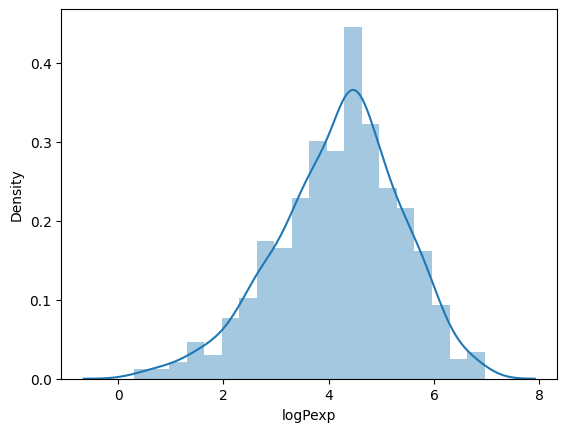

In [43]:
sns.distplot(data['logPexp'])

/var/folders/_5/577czd8n0h98rgb9kmt_kh2c0000gn/T/ipykernel_11881/3082557857.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['pH'])


<Axes: xlabel='pH', ylabel='Density'>

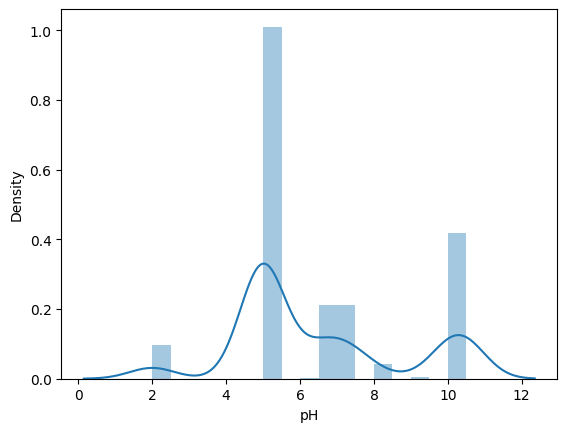

In [45]:
sns.distplot(data['pH'])

In [47]:
#Convert SMILES to 2D molecules:
molecules = data.SMILES.apply(Chem.MolFromSmiles)

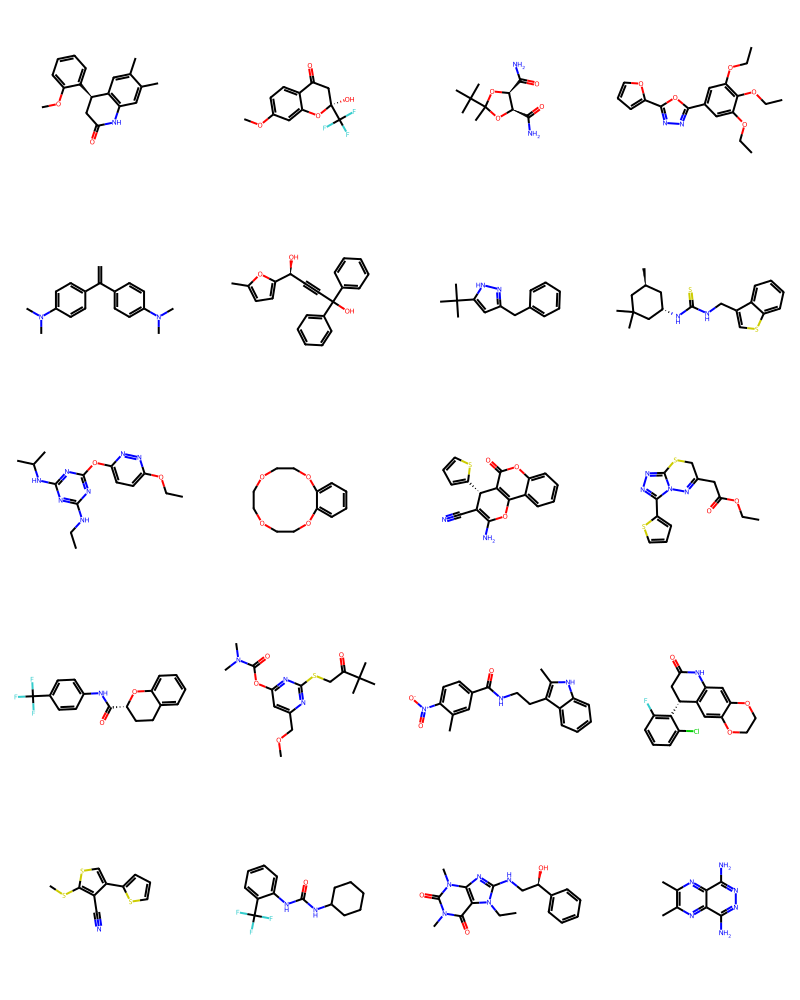

In [49]:
#Display some of the moecules
Draw.MolsToGridImage(molecules[:20],molsPerRow=4)

In [51]:
data.loc[:, 'MolLogP'] = molecules.apply(Descriptors.MolLogP)
data.loc[:, 'HeavyAtomCount'] = molecules.apply(Descriptors.HeavyAtomCount)
data.loc[:, 'HAccept'] = molecules.apply(Descriptors.NumHAcceptors)
data.loc[:, 'Heteroatoms'] = molecules.apply(Descriptors.NumHeteroatoms)
data.loc[:, 'HDonor'] = molecules.apply(Descriptors.NumHDonors)
data.loc[:, 'MolWt'] = molecules.apply(Descriptors.MolWt)
data.loc[:, 'RotableBonds'] = molecules.apply(Descriptors.NumRotatableBonds)
data.loc[:, 'RingCount'] = molecules.apply(Descriptors.RingCount)
data.loc[:, 'Ipc'] = molecules.apply(Descriptors.Ipc)
data.loc[:, 'HallKierAlpha'] = molecules.apply(Descriptors.HallKierAlpha)
data.loc[:, 'NumValenceElectrons'] = molecules.apply(Descriptors.NumValenceElectrons)
data.loc[:, 'SaturatedRings'] = molecules.apply(Descriptors.NumSaturatedRings)
data.loc[:, 'AliphaticRings'] = molecules.apply(Descriptors.NumAliphaticRings)
data.loc[:, 'AromaticRings'] = molecules.apply(Descriptors.NumAromaticRings)

In [53]:
data.head()


,N,ZINC_ID,SMILES,logPexp,pH,MolLogP,HeavyAtomCount,HAccept,Heteroatoms,HDonor,MolWt,RotableBonds,RingCount,Ipc,HallKierAlpha,NumValenceElectrons,SaturatedRings,AliphaticRings,AromaticRings
0,1,ZINC00036522,COC1=CC=CC=C1[C@@H]1CC(=O)NC2=C1C=C(C)C(C)=C2,4.17,5.0,3.78614,21,2,3,1,281.355,2,3,69759.740168,-2.29,108,0,1,2
1,3,ZINC00185379,COC1=CC=C2C(=O)C[C@](O)(OC2=C1)C(F)(F)F,2.79,5.0,1.91130,18,4,7,1,262.183,1,2,7977.096898,-1.76,98,0,1,1
2,4,ZINC12402487,CC(C)(C)C1(C)O[C@@H]([C@@H](O1)C(N)=O)C(N)=O,1.60,6.5,-0.49670,16,4,6,2,230.264,2,1,2165.098769,-1.14,92,1,1,0
3,5,ZINC00055459,CCOC1=CC(=CC(OCC)=C1OCC)C1=NN=C(O1)C1=CC=CO1,3.96,10.5,4.19270,25,7,7,0,344.367,8,3,819166.201010,-2.96,132,0,0,3
4,6,ZINC00056871,CN(C)C1=CC=C(C=C1)C(=C)C1=CC=C(C=C1)N(C)C,5.30,7.3,3.88010,20,2,2,0,266.388,4,2,32168.378171,-2.22,104,0,0,2


### Scatter plot

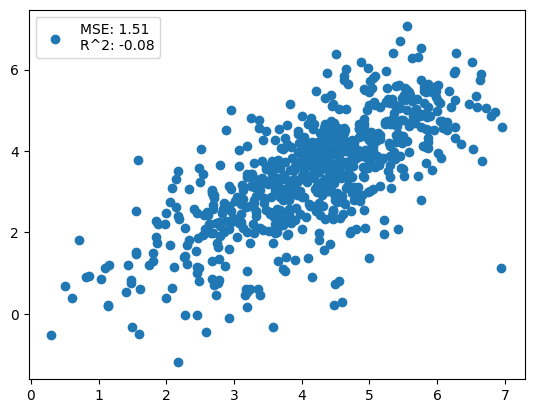

In [60]:
from sklearn.metrics import r2_score, mean_squared_error

r2 = r2_score(data.logPexp, data.MolLogP)
mse = mean_squared_error(data.logPexp, data.MolLogP)
plt.scatter(data.logPexp, data.MolLogP,
            label = "MSE: {:.2f}\nR^2: {:.2f}".format(mse, r2))
plt.legend()
plt.show()

RDKit’s log P predictions have a relatively high mean square error, and a weak R^2 determination for this dataset. 
RDKit’s MolLogP implementation is based on atomic contributions. 
So, we will first try to train our own simple log P model using the RDKit physical descriptors that we generated above.

### Model training

In [65]:
X = data.iloc[:, 6:]
y = data.logPexp
X.head()

,HeavyAtomCount,HAccept,Heteroatoms,HDonor,MolWt,RotableBonds,RingCount,Ipc,HallKierAlpha,NumValenceElectrons,SaturatedRings,AliphaticRings,AromaticRings
0,21,2,3,1,281.355,2,3,69759.740168,-2.29,108,0,1,2
1,18,4,7,1,262.183,1,2,7977.096898,-1.76,98,0,1,1
2,16,4,6,2,230.264,2,1,2165.098769,-1.14,92,1,1,0
3,25,7,7,0,344.367,8,3,819166.201010,-2.96,132,0,0,3
4,20,2,2,0,266.388,4,2,32168.378171,-2.22,104,0,0,2


In [67]:
## Using RandomForest

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Default models
models = {"rf": RandomForestRegressor(n_estimators=100, random_state=42)}

scores = {}
for m in models:
    models[m].fit(X_train, y_train)
    scores[m + "_train"] = models[m].score(X_train, y_train, )
    y_pred = models[m].predict(X_test)
    scores[m + "_test"] = r2_score(y_test, y_pred)
    scores[m + "_mse_test"] = mean_squared_error(y_test, y_pred)

In [79]:
scores = pd.Series(scores).T

In [81]:
scores

rf_train       0.914751
rf_test        0.502639
rf_mse_test    0.683711
dtype: float64

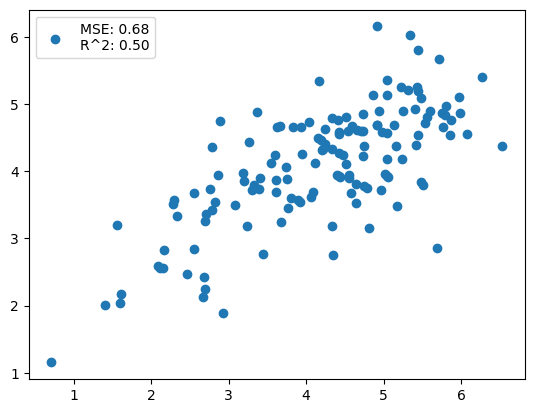

In [83]:
r_2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
plt.scatter(y_test, y_pred, label = "MSE: {:.2f}\nR^2: {:.2f}".format(mse, r_2))
plt.legend()
plt.show()

In [85]:
param_grid = { 
    'n_estimators': [200, 700],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [87]:
estimator = RandomForestRegressor()

In [89]:
grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=5)

In [92]:
grid.fit(X_train, y_train)

/Users/ananya/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
10 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/ananya/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ananya/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/Users/ananya/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/Us

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 700]})

In [93]:
grid.best_estimator_

RandomForestRegressor(max_features='log2', n_estimators=700)

In [96]:
grid.best_params_

{'max_features': 'log2', 'n_estimators': 700}

In [112]:
models = {
    "rf": RandomForestRegressor(
        bootstrap=True,
        criterion='squared_error',  # Note: The default criterion for RandomForestRegressor is 'squared_error', not 'mse'
        max_depth=None,
        max_features='sqrt',  # Note: 'auto' is deprecated, use 'sqrt' instead for random forests
        max_leaf_nodes=None,
        min_impurity_decrease=0.0,
        min_samples_leaf=1,
        min_samples_split=2,
        min_weight_fraction_leaf=0.0,
        n_estimators=200,
        n_jobs=None,
        oob_score=False,
        random_state=None,
        verbose=0,
        warm_start=False
    )
}

scores = {}
for m in models:
    models[m].fit(X_train, y_train)
    scores[m + "_train"] = models[m].score(X_train, y_train, )
    y_pred = models[m].predict(X_test)
    scores[m + "_test"] = r2_score(y_test, y_pred)
    scores[m + "_mse_test"] = mean_squared_error(y_test, y_pred)

In [114]:
scores = pd.Series(scores).T
scores

rf_train       0.919262
rf_test        0.509534
rf_mse_test    0.674232
dtype: float64

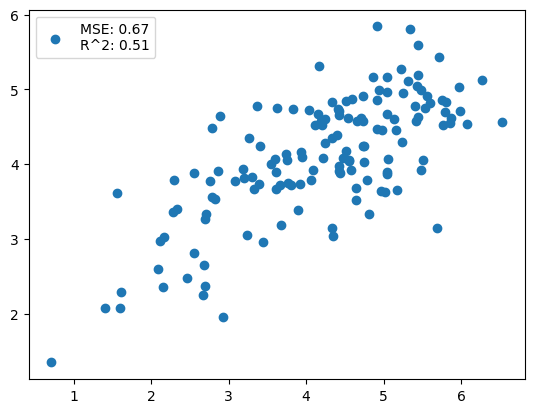

In [116]:
r_2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
plt.scatter(y_test, y_pred, label = "MSE: {:.2f}\nR^2: {:.2f}".format(mse, r_2))
plt.legend()
plt.show()

In [124]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor

# Models to evaluate
models = {
    "RandomForest": RandomForestRegressor(
        n_estimators=200,
        bootstrap=True,
        criterion='squared_error',  # Use 'squared_error' instead of 'mse'
        max_depth=None,
        max_features='sqrt',  # Use 'sqrt' instead of 'auto'
        min_impurity_decrease=0.0,
        min_samples_leaf=1,
        min_samples_split=2,
        min_weight_fraction_leaf=0.0,
        n_jobs=None,
        oob_score=False,
        random_state=42,
        verbose=0,
        warm_start=False
    ),
    "SVR": SVR(gamma='auto'),
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42)
}

scores = {}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate scores
    scores[name] = {
        "r2_train": model.score(X_train, y_train),
        "r2_test": r2_score(y_test, y_pred),
        "mse_test": mean_squared_error(y_test, y_pred)
    }

# Output the scores
scores_df = pd.DataFrame(scores).T
print(scores_df)

                  r2_train   r2_test  mse_test
RandomForest      0.918081  0.486880  0.705373
SVR               0.769848 -0.000744  1.375698
LinearRegression  0.508141  0.523277  0.655340
Ridge             0.508123  0.522342  0.656625
DecisionTree      1.000000  0.184775  1.120670
GradientBoosting  0.748497  0.520334  0.659386


/Users/ananya/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.85901e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


In [134]:
# Model names as index
index = ['RandomForest', 'SVR', 'LinearRegression', 'Ridge', 'DecisionTree', 'GradientBoosting']

# Create DataFrame
scores_df = pd.DataFrame(scores_df, index=index)

# Reset index to make 'Model' a column
scores_df.reset_index(inplace=True)
scores_df.rename(columns={'index': 'Model'}, inplace=True)

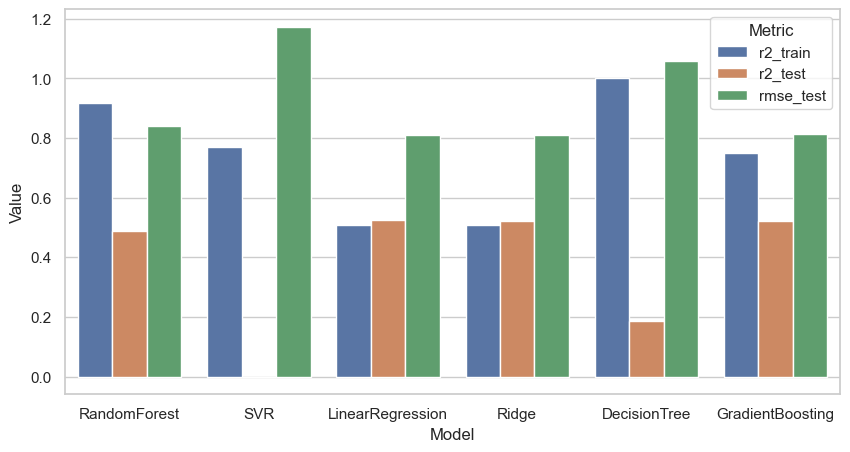

In [154]:
# Calculate RMSE
scores_df['rmse_test'] = np.sqrt(scores_df['mse_test'])

# Melt the DataFrame
df_melted = scores_df.melt(id_vars='Model', value_vars=['r2_train', 'r2_test', 'rmse_test'],
                    var_name='Metric', value_name='Value')

# Plot
plt.figure(figsize=(10, 5))

# Plot with Seaborn
sns.set_theme(style="whitegrid")
sns.barplot(x='Model', y='Value', hue='Metric', data=df_melted)

# Show plot
plt.show()